# **TP2**

##*Organización de Datos (75.06/95.58) - Primer Cuatrimestre 2021*

###### Julio de 2021
---

In [1]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Importamos los archivos de entrada desde google drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/file/d/1d3bvCoox6nxGIWx81EMEQl_hJ1Y0Jp1q/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_values.csv')

train_values=pd.read_csv('train_values.csv', index_col='building_id')

In [4]:
link = 'https://drive.google.com/file/d/1zsOf_CScGSl6O2CBbgQUX7TH3CALpXbl/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_labels.csv')

train_labels=pd.read_csv('train_labels.csv', index_col='building_id')

#Damage grade:
#1 - Low damage
#2 - Medium damage
#3 - Serious damage


In [5]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

#metric
from sklearn.metrics import f1_score

In [6]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
cat_cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type',
          'position','plan_configuration','legal_ownership_status','geo_level_1_id','geo_level_2_id','geo_level_3_id']
for cc in cat_cols:
    train_values[cc]=train_values[cc].astype('category')

In [8]:
X_dev = train_values

Y_dev = train_labels['damage_grade'].astype('category')

Y_dev


building_id
802906    3
28830     2
94947     3
590882    2
201944    3
         ..
688636    2
669485    3
602512    3
151409    2
747594    3
Name: damage_grade, Length: 260601, dtype: category
Categories (3, int64): [1, 2, 3]

In [9]:
from sklearn.model_selection import train_test_split

seed=2

valsize=0.25
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=valsize, random_state=seed)

In [10]:
Y_dev_resc=((Y_dev).astype(int)-1).astype('category')
Y_train_resc=((Y_train).astype(int)-1).astype('category')
Y_val_resc=((Y_val).astype(int)-1).astype('category')

# XGBoost

In [60]:
import xgboost as xgb
from xgboost import XGBClassifier

In [12]:
import time

In [52]:
from sklearn.model_selection import cross_val_score, cross_validate

In [13]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Scoring for hyperopt

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train_subset_enc, label=Y_train_resc)
    dvalid = xgb.DMatrix(X_val_subset_enc, label=Y_val_resc)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=False)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = f1_score(Y_val_resc, predictions, average='micro')
    print("\tScore {0}\n\n".format(score))
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

# Set S1:

In [14]:
#Numericas
X_train_num=X_train.select_dtypes(exclude='category')
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='geo_level')))]
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='has_')))]
col1=X_train_num.columns.tolist()

#El resto
col2=X_train.filter(like='type').columns.tolist()
col3=['has_superstructure_mud_mortar_stone','has_superstructure_cement_mortar_brick','has_superstructure_rc_engineered','has_superstructure_rc_non_engineered']
cols=col1+col2+col3+['geo_level_1_id']

In [15]:
X_train_subset = X_train[cols]
X_val_subset = X_val[cols]

#Drop count_floors
X_train_subset = X_train_subset.drop(columns=['count_floors_pre_eq'])
X_val_subset = X_val_subset.drop(columns=['count_floors_pre_eq'])

X_train_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

## Encodeamos geolevel1

In [16]:
df_0=X_train_subset.merge(Y_train, left_index=True, right_index=True, how='inner')
df=df_0[['damage_grade','geo_level_1_id']].copy().set_index(['damage_grade','geo_level_1_id'])
df['countingindex']=1
df=df.groupby(['damage_grade','geo_level_1_id']).agg({'countingindex':'sum'}).unstack().droplevel(0,axis=1).fillna(0)
df

geo_level_1_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
damage_grade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,246.0,325.0,57.0,184.0,384.0,347.0,1566.0,778.0,489.0,422.0,928.0,279.0,149.0,1453.0,146.0,118.0,146.0,217.0,50.0,33.0,2523.0,239.0,571.0,56.0,202.0,361.0,6054.0,356.0,0.0,7.0,186.0
2,2288.0,1490.0,467.0,3408.0,8299.0,1535.0,12203.0,8557.0,6415.0,2060.0,9104.0,3487.0,1701.0,4650.0,967.0,1286.0,2448.0,2939.0,583.0,182.0,8885.0,4392.0,3415.0,580.0,664.0,3263.0,9452.0,4557.0,112.0,255.0,1594.0
3,445.0,223.0,181.0,2051.0,2143.0,171.0,4562.0,5048.0,7384.0,497.0,6544.0,2375.0,518.0,1005.0,197.0,356.0,711.0,13232.0,1762.0,49.0,1523.0,6528.0,624.0,205.0,91.0,580.0,1484.0,4517.0,74.0,28.0,232.0


In [17]:
frac_df=np.divide(np.array(df.iloc[0]),np.array(df.sum(axis=0)))
frac_df=pd.concat([pd.Series(frac_df), pd.Series(np.divide(np.array(df.iloc[1]),np.array(df.sum(axis=0))))],axis=1,keys=['1','2'])
frac_df=pd.concat([frac_df, pd.Series(np.divide(np.array(df.iloc[2]),np.array(df.sum(axis=0))))],axis=1)
frac_df=frac_df.rename(columns={0:'3'})
frac_df

,1,2,3
0,0.082578,0.768043,0.149379
1,0.159470,0.731109,0.109421
2,0.080851,0.662411,0.256738
3,0.032607,0.603934,0.363459
4,0.035470,0.766580,0.197949
5,0.169021,0.747686,0.083293
6,0.085429,0.665703,0.248868
7,0.054092,0.594938,0.350970
8,0.034225,0.448978,0.516797
9,0.141658,0.691507,0.166835


In [18]:
X_train_subset.head()

,age,area_percentage,height_percentage,count_families,foundation_type,roof_type,ground_floor_type,other_floor_type,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,geo_level_1_id
building_id,,,,,,,,,,,,,
984478,20,8,5,1,r,q,f,q,1,0,0,0,10
33931,20,6,9,1,r,n,f,q,1,0,0,0,21
599202,20,6,4,1,r,n,f,q,1,0,0,0,17
692573,20,12,6,0,r,q,f,q,1,0,0,0,21
719424,10,8,5,1,r,n,f,q,1,1,0,0,26


In [19]:
print(X_train_subset.shape)
X_train_subset_enc=X_train_subset.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_subset_enc=X_train_subset_enc.drop(columns='geo_level_1_id')
print(X_train_subset_enc.shape)
X_train_subset_enc=pd.get_dummies(X_train_subset_enc)
print(X_train_subset_enc.shape)
X_train_subset_enc.head()

(195450, 13)
(195450, 15)
(195450, 28)


,age,area_percentage,height_percentage,count_families,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
984478,20,8,5,1,1,0,0,0,0.055985,0.549228,0.394788,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0
33931,20,6,9,1,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
599202,20,6,4,1,1,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
692573,20,12,6,0,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0
719424,10,8,5,1,1,1,0,0,0.356327,0.556327,0.087345,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [20]:
print(X_val_subset.shape)
X_val_subset_enc=X_val_subset.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_subset_enc=X_val_subset_enc.drop(columns='geo_level_1_id')
print(X_val_subset_enc.shape)
X_val_subset_enc=pd.get_dummies(X_val_subset_enc)
print(X_val_subset_enc.shape)
X_val_subset_enc.head()

(65151, 13)
(65151, 15)
(65151, 28)


,age,area_percentage,height_percentage,count_families,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
624213,5,6,7,1,1,0,0,0,0.085429,0.665703,0.248868,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
393391,20,8,5,1,1,0,0,0,0.000000,0.602151,0.397849,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
615537,30,3,6,0,1,0,0,0,0.034225,0.448978,0.516797,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
351011,70,11,6,1,1,0,0,0,0.169021,0.747686,0.083293,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
638354,5,16,12,2,0,1,0,1,0.013241,0.179339,0.807420,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0


In [21]:
X_train_subset_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     195450 non-null  int64  
 1   area_percentage                         195450 non-null  int64  
 2   height_percentage                       195450 non-null  int64  
 3   count_families                          195450 non-null  int64  
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64  
 5   has_superstructure_cement_mortar_brick  195450 non-null  int64  
 6   has_superstructure_rc_engineered        195450 non-null  int64  
 7   has_superstructure_rc_non_engineered    195450 non-null  int64  
 8   Frac_damage_1                           195450 non-null  float64
 9   Frac_damage_2                           195450 non-null  float64
 10  Frac_damage_3                          

# Estudiamos el comportamiento con los parámetos, de a uno

## max_depth

In [ ]:
pipe = make_pipeline(XGBClassifier(objective='multi:softmax',metrics='mlogloss',num_class=3,n_estimators=200,learning_rate=1,gamma= 0,colsample_bytree= 1,subsample=1,reg_alpha=10,nthread=1,booster='gbtree',tree_method='exact',random_state=2))
pipe

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=1,
                               max_delta_step=0, max_depth=3,
                               metrics='mlogloss', min_child_weight=1,
                               missing=None, n_estimators=200, n_jobs=1,
                               nthread=1, num_class=3,
                               objective='multi:softmax', random_state=2,
                               reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               tree_method='exact', verbosity=1))],
         verbose=False)

In [ ]:
max_d=[2,3,4,5,6,7]
param_grid = {'xgbclassifier__max_depth': max_d}
gs = GridSearchCV(pipe, param_grid,  scoring= 'f1_micro' , cv=3)
gs.fit(X_train_subset_enc, Y_train_resc.values.ravel())
scores_maxd=gs.cv_results_['mean_test_score']

Text(0.5, 1.0, 'XGBoost: set S1 ($n\\_estimators$=200)')

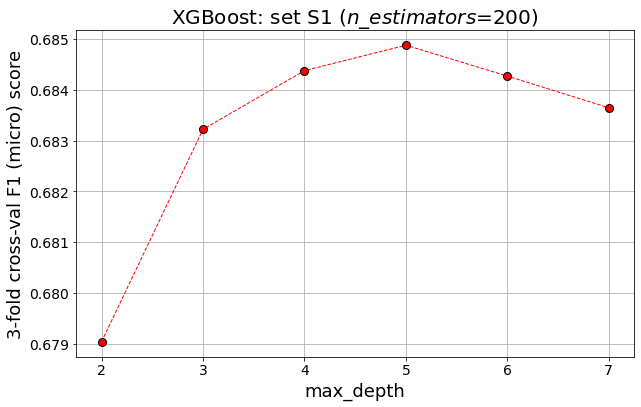

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(zorder=0)
plt.plot(max_d, scores_maxd, 'o--', color='red', markeredgecolor = 'k',  linewidth=1, markersize=8)
plt.xlabel(r'max_depth',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('3-fold cross-val F1 (micro) score',fontsize=18)

plt.title(r'XGBoost: set S1 ($n\_estimators$=200)',fontsize=20)

## learning_rate

In [ ]:
pipe = make_pipeline(XGBClassifier(objective='multi:softmax',metrics='mlogloss',num_class=3,n_estimators=200,max_depth=5,gamma= 0,colsample_bytree= 1,subsample=1,reg_alpha=10,nthread=1,booster='gbtree',tree_method='exact',random_state=2))
pipe

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               metrics='mlogloss', min_child_weight=1,
                               missing=None, n_estimators=200, n_jobs=1,
                               nthread=1, num_class=3,
                               objective='multi:softmax', random_state=2,
                               reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               tree_method='exact', verbosity=1))],
         verbose=False)

In [ ]:
eta=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
param_grid = {'xgbclassifier__learning_rate': eta}
gs = GridSearchCV(pipe, param_grid,  scoring= 'f1_micro' , cv=3)
gs.fit(X_train_subset_enc, Y_train_resc.values.ravel())
scores_eta=gs.cv_results_['mean_test_score']

Text(0.5, 1.0, 'XGBoost: set S1 ($n\\_estimators$=200, $max\\_depth$=5)')

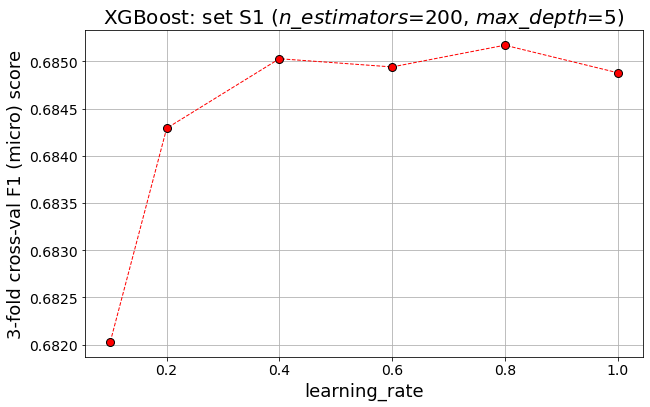

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(zorder=0)
plt.plot(eta, scores_eta, 'o--', color='red', markeredgecolor = 'k',  linewidth=1, markersize=8)
plt.xlabel(r'learning_rate',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('3-fold cross-val F1 (micro) score',fontsize=18)

plt.title(r'XGBoost: set S1 ($n\_estimators$=200, $max\_depth$=5)',fontsize=20)

## n_est

In [55]:
def XGB_model_train_test(n_est):
  model = XGBClassifier(objective='multi:softmax',metrics='mlogloss',num_class=3,n_estimators=n_est,max_depth=5,gamma= 0,colsample_bytree= 1,subsample=1,reg_alpha=10,nthread=1,booster='gbtree',tree_method='exact',random_state=2)
  return np.mean(cross_val_score(model,X_train_subset_enc, Y_train_resc.values.ravel(), cv=3,scoring=("f1_micro")))

In [56]:
n_est=[100,200,300,400,500,600]
scores_nest = []
for n_e in n_est:
  print(n_e)
  scores_nest.append(XGB_model_train_test(n_e))

scores_nest

100
200
300
400
500
600


[0.678429265796879,
 0.6820312100281402,
 0.6835303146584805,
 0.6846098746482476,
 0.6846354566385265,
 0.6846815042210285]

Text(0.5, 1.0, 'XGBoost: set S1 ($max\\_depth$=5, $learning\\_rate=0.8$)')

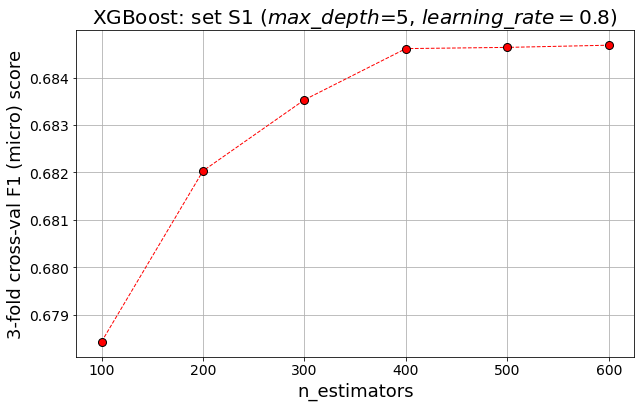

In [57]:
plt.figure(figsize=(10,6))
plt.grid(zorder=0)
plt.plot(n_est, scores_nest, 'o--', color='red', markeredgecolor = 'k',  linewidth=1, markersize=8)
plt.xlabel(r'n_estimators',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('3-fold cross-val F1 (micro) score',fontsize=18)

plt.title(r'XGBoost: set S1 ($max\_depth$=5, $learning\_rate=0.8$)',fontsize=20)

# Hyperopt 


In [ ]:
start = time.time()

def optimize(trials, 
             random_state=2):
    space = {
        'n_estimators': hp.quniform('n_estimators', 400, 450, 25),
        'eta': hp.quniform('eta', 0.8, 1.0, 0.1),
        'max_depth':  hp.choice('max_depth', np.arange(4, 7, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 4, 1),  
        'subsample': hp.quniform('subsample', 0.7, 1, 0.1), 
        'gamma': hp.quniform('gamma', 0.0, 2.0, 0.5),  
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1), 
        'eval_metric': 'mlogloss',
        'objective': 'multi:softmax',
        'num_class':3,
        'alpha': hp.quniform('alpha', 0.0, 2.0, 0.5), 
        'nthread': 1,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, 
                max_evals=100) 
    return best


trials = Trials()

best_hyperparams = optimize(trials)
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

end = time.time()
print(end - start)

Training with params: 
{'alpha': 1.0, 'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.9, 'eval_metric': 'mlogloss', 'gamma': 1.0, 'max_depth': 5, 'min_child_weight': 3.0, 'n_estimators': 450.0, 'nthread': 1, 'num_class': 3, 'objective': 'multi:softmax', 'seed': 2, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
	Score 0.6839188961028995


Training with params: 
{'alpha': 2.0, 'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.9, 'eval_metric': 'mlogloss', 'gamma': 1.5, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 450.0, 'nthread': 1, 'num_class': 3, 'objective': 'multi:softmax', 'seed': 2, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
	Score 0.685315651333057


Training with params: 
{'alpha': 1.5, 'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 1.0, 'eval_metric': 'mlogloss', 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 3.0, 'n_estimators': 425.0, 'nthread': 1, 'num_class': 3, 'objective': 'multi:softmax', 'seed': 2, 'silent': 1, 'subsa

Los mejores parámetros son: {'alpha': 0.5,
 'booster': 'gbtree', 'colsample_bytree': 0.6,
 'eta': 0.8, 'eval_metric': 'mlogloss', 'gamma': 2.0,  'max_depth': 6,
 'min_child_weight': 2.0, 'n_estimators': 425, 'nthread': 1,
 'num_class': 3, 'objective': 'multi:softmax',
 'seed': 2, 'silent': 1, 'subsample': 1.0, 'tree_method': 'exact'}

# XGBoost con los mejores parámetros

In [58]:
params={'alpha': 0.5,
 'booster': 'gbtree',
 'colsample_bytree': 0.6,
 'eta': 0.8,
 'eval_metric': 'mlogloss',
 'gamma': 2.0,
 'max_depth': 6,
 'min_child_weight': 2.0,
 'n_estimators': 425,
 'nthread': 1,
 'num_class': 3,
 'objective': 'multi:softmax',
 'seed': 2,
 'silent': 1,
 'subsample': 1.0,
 'tree_method': 'exact'}

## Sets: 

### S1

In [78]:
X_train_s1=X_train_subset.copy()
X_val_s1=X_val_subset.copy()

X_train_s1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

### S2

In [79]:
X_train_s2=X_train.copy()
X_train_s2.drop(columns=['geo_level_2_id','geo_level_3_id','count_floors_pre_eq'],inplace=True)

X_val_s2=X_val.copy()
X_val_s2.drop(columns=['geo_level_2_id','geo_level_3_id','count_floors_pre_eq'],inplace=True)

X_train_s2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   age                                     195450 non-null  int64   
 2   area_percentage                         195450 non-null  int64   
 3   height_percentage                       195450 non-null  int64   
 4   land_surface_condition                  195450 non-null  category
 5   foundation_type                         195450 non-null  category
 6   roof_type                               195450 non-null  category
 7   ground_floor_type                       195450 non-null  category
 8   other_floor_type                        195450 non-null  category
 9   position                                195450 non-null  category
 10  plan_configuration         

### S3

In [80]:
X_train_s3=X_train.copy()
X_train_s3.drop(columns=['geo_level_2_id','geo_level_3_id'],inplace=True)
X_train_s3['Height_Area']=X_train_s3['height_percentage']/X_train_s3['area_percentage']

X_val_s3=X_val.copy()
X_val_s3.drop(columns=['geo_level_2_id','geo_level_3_id'],inplace=True)
X_val_s3['Height_Area']=X_val_s3['height_percentage']/X_val_s3['area_percentage']

X_train_s3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 37 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          195450 non-null  category
 1   count_floors_pre_eq                     195450 non-null  int64   
 2   age                                     195450 non-null  int64   
 3   area_percentage                         195450 non-null  int64   
 4   height_percentage                       195450 non-null  int64   
 5   land_surface_condition                  195450 non-null  category
 6   foundation_type                         195450 non-null  category
 7   roof_type                               195450 non-null  category
 8   ground_floor_type                       195450 non-null  category
 9   other_floor_type                        195450 non-null  category
 10  position                   

# Encodeamos geo_level_1_id: frac



In [81]:
df_0=X_train.merge(Y_train, left_index=True, right_index=True, how='inner')
df=df_0[['damage_grade','geo_level_1_id']].copy().set_index(['damage_grade','geo_level_1_id'])
df['countingindex']=1
df=df.groupby(['damage_grade','geo_level_1_id']).agg({'countingindex':'sum'}).unstack().droplevel(0,axis=1).fillna(0)
df

geo_level_1_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
damage_grade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,246.0,325.0,57.0,184.0,384.0,347.0,1566.0,778.0,489.0,422.0,928.0,279.0,149.0,1453.0,146.0,118.0,146.0,217.0,50.0,33.0,2523.0,239.0,571.0,56.0,202.0,361.0,6054.0,356.0,0.0,7.0,186.0
2,2288.0,1490.0,467.0,3408.0,8299.0,1535.0,12203.0,8557.0,6415.0,2060.0,9104.0,3487.0,1701.0,4650.0,967.0,1286.0,2448.0,2939.0,583.0,182.0,8885.0,4392.0,3415.0,580.0,664.0,3263.0,9452.0,4557.0,112.0,255.0,1594.0
3,445.0,223.0,181.0,2051.0,2143.0,171.0,4562.0,5048.0,7384.0,497.0,6544.0,2375.0,518.0,1005.0,197.0,356.0,711.0,13232.0,1762.0,49.0,1523.0,6528.0,624.0,205.0,91.0,580.0,1484.0,4517.0,74.0,28.0,232.0


In [82]:
frac_gl1=np.divide(np.array(df.iloc[0]),np.array(df.sum(axis=0)))
frac_gl1=pd.concat([pd.Series(frac_gl1), pd.Series(np.divide(np.array(df.iloc[1]),np.array(df.sum(axis=0))))],axis=1,keys=['1','2'])
frac_gl1=pd.concat([frac_gl1, pd.Series(np.divide(np.array(df.iloc[2]),np.array(df.sum(axis=0))))],axis=1)
frac_gl1=frac_gl1.rename(columns={0:'3'})
frac_gl1

,1,2,3
0,0.082578,0.768043,0.149379
1,0.159470,0.731109,0.109421
2,0.080851,0.662411,0.256738
3,0.032607,0.603934,0.363459
4,0.035470,0.766580,0.197949
5,0.169021,0.747686,0.083293
6,0.085429,0.665703,0.248868
7,0.054092,0.594938,0.350970
8,0.034225,0.448978,0.516797
9,0.141658,0.691507,0.166835


## S1

In [83]:
print(X_train_s1.shape)
X_train_s1_enc=X_train_s1.merge(frac_gl1,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_s1_enc=X_train_s1_enc.drop(columns='geo_level_1_id')
print(X_train_s1_enc.shape)
X_train_s1_enc=pd.get_dummies(X_train_s1_enc)
print(X_train_s1_enc.shape)
X_train_s1_enc.info()

(195450, 13)
(195450, 15)
(195450, 28)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     195450 non-null  int64  
 1   area_percentage                         195450 non-null  int64  
 2   height_percentage                       195450 non-null  int64  
 3   count_families                          195450 non-null  int64  
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64  
 5   has_superstructure_cement_mortar_brick  195450 non-null  int64  
 6   has_superstructure_rc_engineered        195450 non-null  int64  
 7   has_superstructure_rc_non_engineered    195450 non-null  int64  
 8   Frac_damage_1                           195450 non-null  float64
 9   Frac_damage_2                           195450 non-null  float64
 10  

In [84]:
print(X_val_s1.shape)
X_val_s1_enc=X_val_s1.merge(frac_gl1,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_s1_enc=X_val_s1_enc.drop(columns='geo_level_1_id')
print(X_val_s1_enc.shape)
X_val_s1_enc=pd.get_dummies(X_val_s1_enc)
print(X_val_s1_enc.shape)
X_val_s1_enc.info()

(65151, 13)
(65151, 15)
(65151, 28)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65151 entries, 624213 to 283760
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   age                                     65151 non-null  int64  
 1   area_percentage                         65151 non-null  int64  
 2   height_percentage                       65151 non-null  int64  
 3   count_families                          65151 non-null  int64  
 4   has_superstructure_mud_mortar_stone     65151 non-null  int64  
 5   has_superstructure_cement_mortar_brick  65151 non-null  int64  
 6   has_superstructure_rc_engineered        65151 non-null  int64  
 7   has_superstructure_rc_non_engineered    65151 non-null  int64  
 8   Frac_damage_1                           65151 non-null  float64
 9   Frac_damage_2                           65151 non-null  float64
 10  Frac_damage_3   

In [85]:
dtrain = xgb.DMatrix(X_train_s1_enc, label=Y_train_resc)
dvalid = xgb.DMatrix(X_val_s1_enc, label=Y_val_resc)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = int(params['n_estimators'])

xgb_clf = xgb.train(dtrain=dtrain,params=params,num_boost_round=num_round,evals=watchlist,verbose_eval=True)

[0]	eval-mlogloss:0.843561	train-mlogloss:0.841211
[1]	eval-mlogloss:0.753372	train-mlogloss:0.749955
[2]	eval-mlogloss:0.720219	train-mlogloss:0.715936
[3]	eval-mlogloss:0.704769	train-mlogloss:0.699145
[4]	eval-mlogloss:0.696771	train-mlogloss:0.690328
[5]	eval-mlogloss:0.691601	train-mlogloss:0.684341
[6]	eval-mlogloss:0.688344	train-mlogloss:0.680464
[7]	eval-mlogloss:0.685993	train-mlogloss:0.677452
[8]	eval-mlogloss:0.684213	train-mlogloss:0.674789
[9]	eval-mlogloss:0.682719	train-mlogloss:0.672792
[10]	eval-mlogloss:0.681627	train-mlogloss:0.671209
[11]	eval-mlogloss:0.681133	train-mlogloss:0.670531
[12]	eval-mlogloss:0.680478	train-mlogloss:0.669122
[13]	eval-mlogloss:0.679806	train-mlogloss:0.668045
[14]	eval-mlogloss:0.679749	train-mlogloss:0.667454
[15]	eval-mlogloss:0.679384	train-mlogloss:0.666853
[16]	eval-mlogloss:0.679119	train-mlogloss:0.666332
[17]	eval-mlogloss:0.678848	train-mlogloss:0.665902
[18]	eval-mlogloss:0.678146	train-mlogloss:0.664675
[19]	eval-mlogloss:0.6

In [86]:
y_pred=xgb_clf.predict(xgb.DMatrix(X_val_s1_enc))
f1_val=f1_score(Y_val_resc, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.687510552409019


Text(0.5, 1.0, 'XGBoost: set S1')

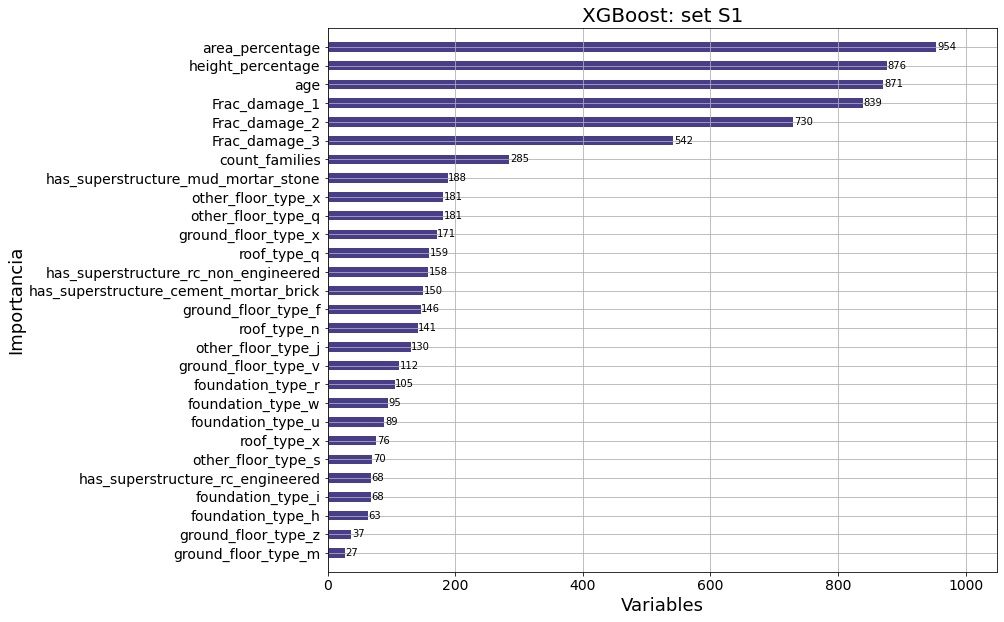

In [89]:
plt.rcParams["figure.figsize"]=[12,10]
xgb.plot_importance(xgb_clf,color='darkslateblue',height=0.5)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'XGBoost: set S1',fontsize=20)


## S2

In [102]:
print(X_train_s2.shape)
X_train_s2_enc=X_train_s2.merge(frac_gl1,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_s2_enc=X_train_s2_enc.drop(columns='geo_level_1_id')
print(X_train_s2_enc.shape)
X_train_s2_enc=pd.get_dummies(X_train_s2_enc)
print(X_train_s2_enc.shape)
X_train_s2_enc.info()

(195450, 35)
(195450, 37)
(195450, 67)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 67 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     195450 non-null  int64  
 1   area_percentage                         195450 non-null  int64  
 2   height_percentage                       195450 non-null  int64  
 3   has_superstructure_adobe_mud            195450 non-null  int64  
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64  
 5   has_superstructure_stone_flag           195450 non-null  int64  
 6   has_superstructure_cement_mortar_stone  195450 non-null  int64  
 7   has_superstructure_mud_mortar_brick     195450 non-null  int64  
 8   has_superstructure_cement_mortar_brick  195450 non-null  int64  
 9   has_superstructure_timber               195450 non-null  int64  
 10  

In [103]:
print(X_val_s2.shape)
X_val_s2_enc=X_val_s2.merge(frac_gl1,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_s2_enc=X_val_s2_enc.drop(columns='geo_level_1_id')
print(X_val_s2_enc.shape)
X_val_s2_enc=pd.get_dummies(X_val_s2_enc)
print(X_val_s2_enc.shape)
X_val_s2_enc.info()

(65151, 35)
(65151, 37)
(65151, 67)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65151 entries, 624213 to 283760
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   age                                     65151 non-null  int64  
 1   area_percentage                         65151 non-null  int64  
 2   height_percentage                       65151 non-null  int64  
 3   has_superstructure_adobe_mud            65151 non-null  int64  
 4   has_superstructure_mud_mortar_stone     65151 non-null  int64  
 5   has_superstructure_stone_flag           65151 non-null  int64  
 6   has_superstructure_cement_mortar_stone  65151 non-null  int64  
 7   has_superstructure_mud_mortar_brick     65151 non-null  int64  
 8   has_superstructure_cement_mortar_brick  65151 non-null  int64  
 9   has_superstructure_timber               65151 non-null  int64  
 10  has_superstructu

In [104]:
dtrain = xgb.DMatrix(X_train_s2_enc, label=Y_train_resc)
dvalid = xgb.DMatrix(X_val_s2_enc, label=Y_val_resc)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = int(params['n_estimators'])

xgb_clf = xgb.train(dtrain=dtrain,params=params,num_boost_round=num_round,evals=watchlist,verbose_eval=True)

[0]	eval-mlogloss:0.81311	train-mlogloss:0.811023
[1]	eval-mlogloss:0.744687	train-mlogloss:0.741433
[2]	eval-mlogloss:0.715423	train-mlogloss:0.710747
[3]	eval-mlogloss:0.700021	train-mlogloss:0.694301
[4]	eval-mlogloss:0.690697	train-mlogloss:0.683993
[5]	eval-mlogloss:0.685212	train-mlogloss:0.677563
[6]	eval-mlogloss:0.681696	train-mlogloss:0.673305
[7]	eval-mlogloss:0.679684	train-mlogloss:0.670383
[8]	eval-mlogloss:0.677679	train-mlogloss:0.667972
[9]	eval-mlogloss:0.676226	train-mlogloss:0.665986
[10]	eval-mlogloss:0.675629	train-mlogloss:0.66472
[11]	eval-mlogloss:0.674288	train-mlogloss:0.662702
[12]	eval-mlogloss:0.673388	train-mlogloss:0.661081
[13]	eval-mlogloss:0.67269	train-mlogloss:0.660086
[14]	eval-mlogloss:0.671614	train-mlogloss:0.658513
[15]	eval-mlogloss:0.670934	train-mlogloss:0.657218
[16]	eval-mlogloss:0.6706	train-mlogloss:0.656467
[17]	eval-mlogloss:0.670233	train-mlogloss:0.655494
[18]	eval-mlogloss:0.669848	train-mlogloss:0.654507
[19]	eval-mlogloss:0.669298

In [105]:
y_pred=xgb_clf.predict(xgb.DMatrix(X_val_s2_enc))
f1_val=f1_score(Y_val_resc, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6941106045954782


Text(0.5, 1.0, 'XGBoost: set S2')

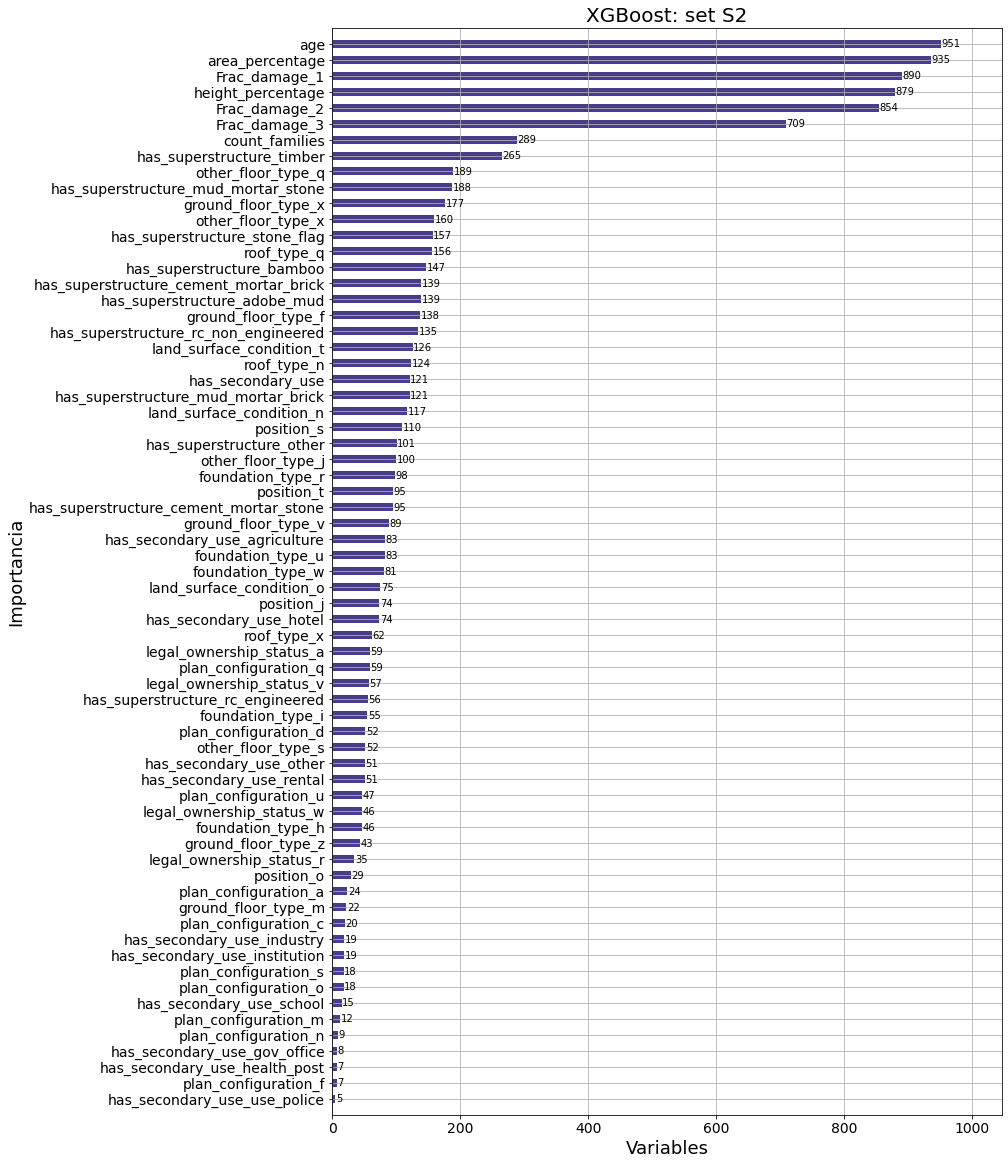

In [106]:
plt.rcParams["figure.figsize"]=[12,20]
xgb.plot_importance(xgb_clf,color='darkslateblue',height=0.5)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'XGBoost: set S2',fontsize=20)


## S3

In [97]:
print(X_train_s3.shape)
X_train_s3_enc=X_train_s3.merge(frac_gl1,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_s3_enc=X_train_s3_enc.drop(columns='geo_level_1_id')
print(X_train_s3_enc.shape)
X_train_s3_enc=pd.get_dummies(X_train_s3_enc)
print(X_train_s3_enc.shape)
X_train_s3_enc.info()

(195450, 37)
(195450, 39)
(195450, 69)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 69 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     195450 non-null  int64  
 1   age                                     195450 non-null  int64  
 2   area_percentage                         195450 non-null  int64  
 3   height_percentage                       195450 non-null  int64  
 4   has_superstructure_adobe_mud            195450 non-null  int64  
 5   has_superstructure_mud_mortar_stone     195450 non-null  int64  
 6   has_superstructure_stone_flag           195450 non-null  int64  
 7   has_superstructure_cement_mortar_stone  195450 non-null  int64  
 8   has_superstructure_mud_mortar_brick     195450 non-null  int64  
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64  
 10  

In [98]:
print(X_val_s3.shape)
X_val_s3_enc=X_val_s3.merge(frac_gl1,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_s3_enc=X_val_s3_enc.drop(columns='geo_level_1_id')
print(X_val_s3_enc.shape)
X_val_s3_enc=pd.get_dummies(X_val_s3_enc)
print(X_val_s3_enc.shape)
X_val_s3_enc.info()

(65151, 37)
(65151, 39)
(65151, 69)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65151 entries, 624213 to 283760
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   count_floors_pre_eq                     65151 non-null  int64  
 1   age                                     65151 non-null  int64  
 2   area_percentage                         65151 non-null  int64  
 3   height_percentage                       65151 non-null  int64  
 4   has_superstructure_adobe_mud            65151 non-null  int64  
 5   has_superstructure_mud_mortar_stone     65151 non-null  int64  
 6   has_superstructure_stone_flag           65151 non-null  int64  
 7   has_superstructure_cement_mortar_stone  65151 non-null  int64  
 8   has_superstructure_mud_mortar_brick     65151 non-null  int64  
 9   has_superstructure_cement_mortar_brick  65151 non-null  int64  
 10  has_superstructu

In [99]:
dtrain = xgb.DMatrix(X_train_s3_enc, label=Y_train_resc)
dvalid = xgb.DMatrix(X_val_s3_enc, label=Y_val_resc)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = int(params['n_estimators'])

xgb_clf = xgb.train(dtrain=dtrain,params=params,num_boost_round=num_round,evals=watchlist,verbose_eval=True)

[0]	eval-mlogloss:0.815148	train-mlogloss:0.813005
[1]	eval-mlogloss:0.746598	train-mlogloss:0.742181
[2]	eval-mlogloss:0.716575	train-mlogloss:0.711013
[3]	eval-mlogloss:0.702691	train-mlogloss:0.695886
[4]	eval-mlogloss:0.692582	train-mlogloss:0.684749
[5]	eval-mlogloss:0.686296	train-mlogloss:0.677675
[6]	eval-mlogloss:0.682208	train-mlogloss:0.672834
[7]	eval-mlogloss:0.680647	train-mlogloss:0.670637
[8]	eval-mlogloss:0.678524	train-mlogloss:0.667877
[9]	eval-mlogloss:0.676965	train-mlogloss:0.66546
[10]	eval-mlogloss:0.67616	train-mlogloss:0.664123
[11]	eval-mlogloss:0.674852	train-mlogloss:0.662349
[12]	eval-mlogloss:0.673867	train-mlogloss:0.660888
[13]	eval-mlogloss:0.672957	train-mlogloss:0.659401
[14]	eval-mlogloss:0.672446	train-mlogloss:0.658284
[15]	eval-mlogloss:0.670714	train-mlogloss:0.65563
[16]	eval-mlogloss:0.669888	train-mlogloss:0.654244
[17]	eval-mlogloss:0.669262	train-mlogloss:0.65281
[18]	eval-mlogloss:0.668623	train-mlogloss:0.651763
[19]	eval-mlogloss:0.66828

In [100]:
y_pred=xgb_clf.predict(xgb.DMatrix(X_val_s3_enc))
f1_val=f1_score(Y_val_resc, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.697333885895842


Text(0.5, 1.0, 'XGBoost: set S3')

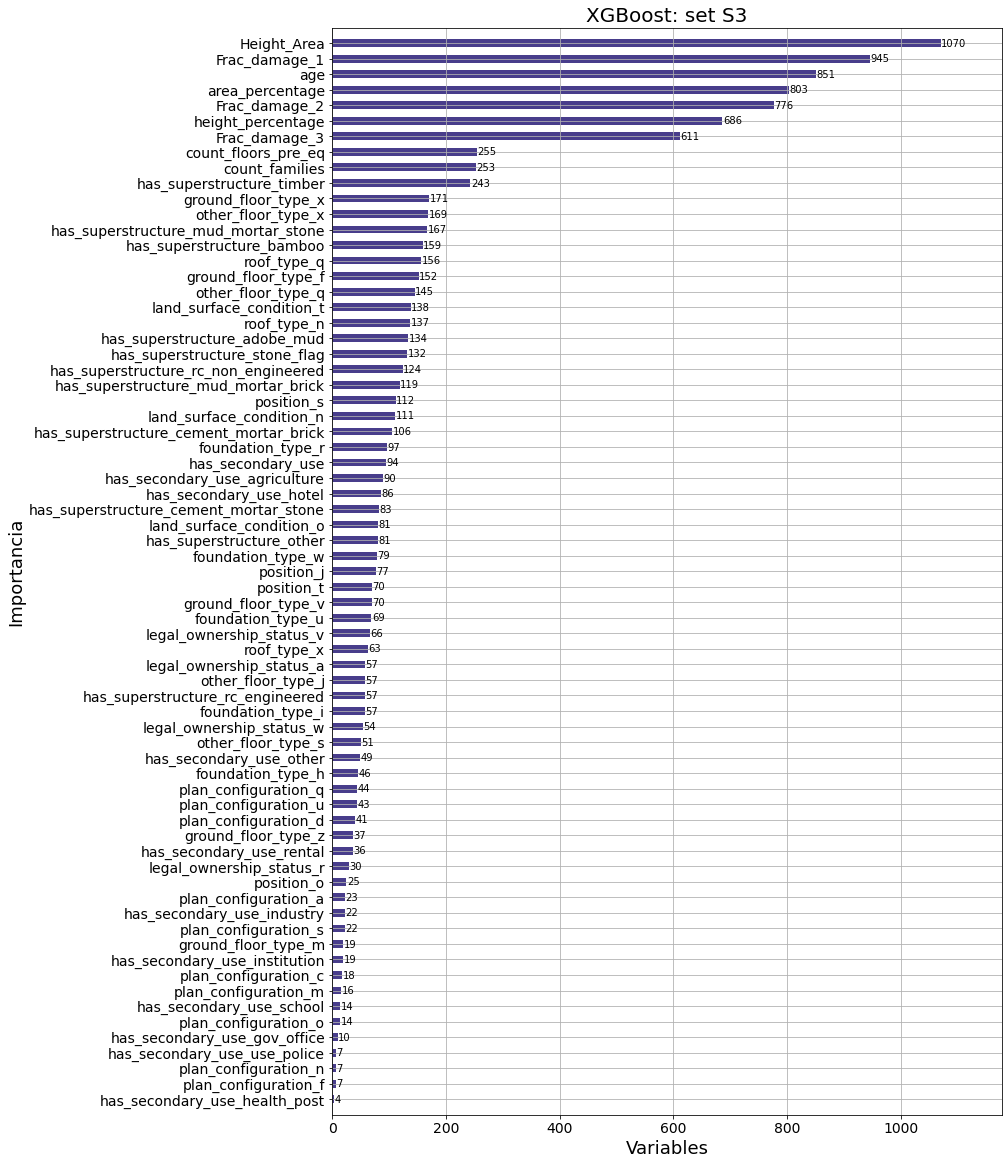

In [101]:
plt.rcParams["figure.figsize"]=[12,20]
xgb.plot_importance(xgb_clf,color='darkslateblue',height=0.5)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'XGBoost: set S3',fontsize=20)


# Encodeamos geo_level_1_id: onehot




## S1

In [108]:
print(X_train_s1.shape)
X_train_s1_oh=pd.get_dummies(X_train_s1)
print(X_train_s1_oh.shape)
X_train_s1_oh.info()

(195450, 13)
(195450, 56)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 56 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     195450 non-null  int64
 1   area_percentage                         195450 non-null  int64
 2   height_percentage                       195450 non-null  int64
 3   count_families                          195450 non-null  int64
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64
 5   has_superstructure_cement_mortar_brick  195450 non-null  int64
 6   has_superstructure_rc_engineered        195450 non-null  int64
 7   has_superstructure_rc_non_engineered    195450 non-null  int64
 8   foundation_type_h                       195450 non-null  uint8
 9   foundation_type_i                       195450 non-null  uint8
 10  foundation_type_r                    

In [109]:
print(X_val_s1.shape)
X_val_s1_oh=pd.get_dummies(X_val_s1)
print(X_val_s1_oh.shape)
X_train_s1_oh.info()

(65151, 13)
(65151, 56)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 56 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     195450 non-null  int64
 1   area_percentage                         195450 non-null  int64
 2   height_percentage                       195450 non-null  int64
 3   count_families                          195450 non-null  int64
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64
 5   has_superstructure_cement_mortar_brick  195450 non-null  int64
 6   has_superstructure_rc_engineered        195450 non-null  int64
 7   has_superstructure_rc_non_engineered    195450 non-null  int64
 8   foundation_type_h                       195450 non-null  uint8
 9   foundation_type_i                       195450 non-null  uint8
 10  foundation_type_r                      

In [110]:
dtrain = xgb.DMatrix(X_train_s1_oh, label=Y_train_resc)
dvalid = xgb.DMatrix(X_val_s1_oh, label=Y_val_resc)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = int(params['n_estimators'])

xgb_clf = xgb.train(dtrain=dtrain,params=params,num_boost_round=num_round,evals=watchlist,verbose_eval=True)

[0]	eval-mlogloss:0.844128	train-mlogloss:0.840641
[1]	eval-mlogloss:0.768595	train-mlogloss:0.764919
[2]	eval-mlogloss:0.739035	train-mlogloss:0.733583
[3]	eval-mlogloss:0.721052	train-mlogloss:0.71482
[4]	eval-mlogloss:0.71253	train-mlogloss:0.705394
[5]	eval-mlogloss:0.705754	train-mlogloss:0.697718
[6]	eval-mlogloss:0.700742	train-mlogloss:0.691981
[7]	eval-mlogloss:0.696972	train-mlogloss:0.687935
[8]	eval-mlogloss:0.69459	train-mlogloss:0.685085
[9]	eval-mlogloss:0.692299	train-mlogloss:0.682423
[10]	eval-mlogloss:0.690146	train-mlogloss:0.680057
[11]	eval-mlogloss:0.688617	train-mlogloss:0.678019
[12]	eval-mlogloss:0.687162	train-mlogloss:0.676127
[13]	eval-mlogloss:0.686421	train-mlogloss:0.674945
[14]	eval-mlogloss:0.685634	train-mlogloss:0.673839
[15]	eval-mlogloss:0.684911	train-mlogloss:0.672804
[16]	eval-mlogloss:0.684221	train-mlogloss:0.671784
[17]	eval-mlogloss:0.683036	train-mlogloss:0.670338
[18]	eval-mlogloss:0.682323	train-mlogloss:0.66937
[19]	eval-mlogloss:0.68166

In [111]:
y_pred=xgb_clf.predict(xgb.DMatrix(X_val_s1_oh))
f1_val=f1_score(Y_val_resc, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6867891513560805


Text(0.5, 1.0, 'XGBoost: set S1 (One Hot Encoding)')

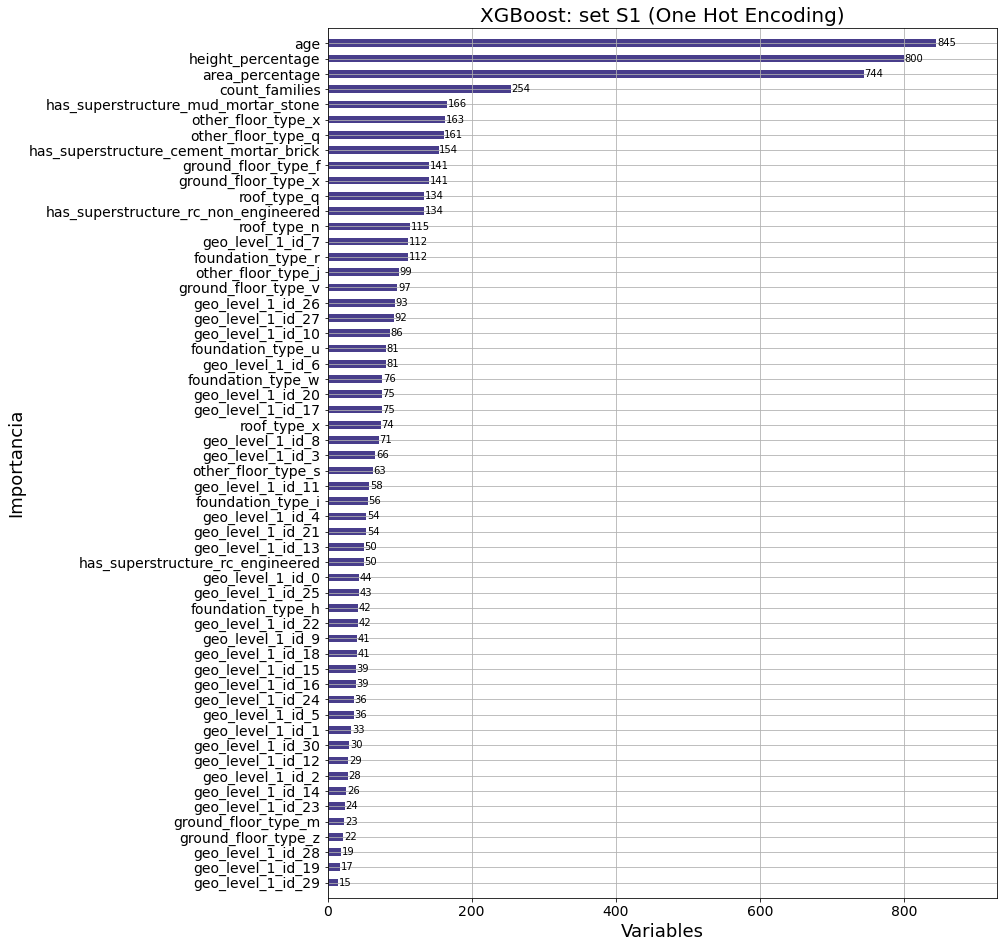

In [114]:
plt.rcParams["figure.figsize"]=[12,16]
xgb.plot_importance(xgb_clf,color='darkslateblue',height=0.5)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'XGBoost: set S1 (One Hot Encoding)',fontsize=20)


## S2

In [115]:
print(X_train_s2.shape)
X_train_s2_oh=pd.get_dummies(X_train_s2)
print(X_train_s2_oh.shape)
X_train_s2_oh.info()

(195450, 35)
(195450, 95)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 95 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     195450 non-null  int64
 1   area_percentage                         195450 non-null  int64
 2   height_percentage                       195450 non-null  int64
 3   has_superstructure_adobe_mud            195450 non-null  int64
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64
 5   has_superstructure_stone_flag           195450 non-null  int64
 6   has_superstructure_cement_mortar_stone  195450 non-null  int64
 7   has_superstructure_mud_mortar_brick     195450 non-null  int64
 8   has_superstructure_cement_mortar_brick  195450 non-null  int64
 9   has_superstructure_timber               195450 non-null  int64
 10  has_superstructure_bamboo            

In [116]:
print(X_val_s2.shape)
X_val_s2_oh=pd.get_dummies(X_val_s2)
print(X_val_s2_oh.shape)
X_train_s2_oh.info()

(65151, 35)
(65151, 95)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 95 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     195450 non-null  int64
 1   area_percentage                         195450 non-null  int64
 2   height_percentage                       195450 non-null  int64
 3   has_superstructure_adobe_mud            195450 non-null  int64
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64
 5   has_superstructure_stone_flag           195450 non-null  int64
 6   has_superstructure_cement_mortar_stone  195450 non-null  int64
 7   has_superstructure_mud_mortar_brick     195450 non-null  int64
 8   has_superstructure_cement_mortar_brick  195450 non-null  int64
 9   has_superstructure_timber               195450 non-null  int64
 10  has_superstructure_bamboo              

In [117]:
dtrain = xgb.DMatrix(X_train_s2_oh, label=Y_train_resc)
dvalid = xgb.DMatrix(X_val_s2_oh, label=Y_val_resc)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = int(params['n_estimators'])

xgb_clf = xgb.train(dtrain=dtrain,params=params,num_boost_round=num_round,evals=watchlist,verbose_eval=True)

[0]	eval-mlogloss:0.841274	train-mlogloss:0.839053
[1]	eval-mlogloss:0.769804	train-mlogloss:0.766586
[2]	eval-mlogloss:0.733686	train-mlogloss:0.729265
[3]	eval-mlogloss:0.717422	train-mlogloss:0.711751
[4]	eval-mlogloss:0.70742	train-mlogloss:0.700822
[5]	eval-mlogloss:0.699554	train-mlogloss:0.691943
[6]	eval-mlogloss:0.694168	train-mlogloss:0.685807
[7]	eval-mlogloss:0.690664	train-mlogloss:0.681818
[8]	eval-mlogloss:0.687483	train-mlogloss:0.677788
[9]	eval-mlogloss:0.685373	train-mlogloss:0.675194
[10]	eval-mlogloss:0.682863	train-mlogloss:0.671911
[11]	eval-mlogloss:0.680739	train-mlogloss:0.669369
[12]	eval-mlogloss:0.67841	train-mlogloss:0.666506
[13]	eval-mlogloss:0.676698	train-mlogloss:0.663912
[14]	eval-mlogloss:0.675268	train-mlogloss:0.662289
[15]	eval-mlogloss:0.674716	train-mlogloss:0.661226
[16]	eval-mlogloss:0.674114	train-mlogloss:0.660296
[17]	eval-mlogloss:0.673297	train-mlogloss:0.658803
[18]	eval-mlogloss:0.672489	train-mlogloss:0.657796
[19]	eval-mlogloss:0.671

In [118]:
y_pred=xgb_clf.predict(xgb.DMatrix(X_val_s2_oh))
f1_val=f1_score(Y_val_resc, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6956915473285138


## S3

In [120]:
print(X_train_s3.shape)
X_train_s3_oh=pd.get_dummies(X_train_s3)
print(X_train_s3_oh.shape)
X_train_s3_oh.info()

(195450, 37)
(195450, 97)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 97 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     195450 non-null  int64  
 1   age                                     195450 non-null  int64  
 2   area_percentage                         195450 non-null  int64  
 3   height_percentage                       195450 non-null  int64  
 4   has_superstructure_adobe_mud            195450 non-null  int64  
 5   has_superstructure_mud_mortar_stone     195450 non-null  int64  
 6   has_superstructure_stone_flag           195450 non-null  int64  
 7   has_superstructure_cement_mortar_stone  195450 non-null  int64  
 8   has_superstructure_mud_mortar_brick     195450 non-null  int64  
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64  
 10  has_superstru

In [121]:
print(X_val_s3.shape)
X_val_s3_oh=pd.get_dummies(X_val_s3)
print(X_val_s3_oh.shape)
X_train_s3_oh.info()

(65151, 37)
(65151, 97)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 97 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     195450 non-null  int64  
 1   age                                     195450 non-null  int64  
 2   area_percentage                         195450 non-null  int64  
 3   height_percentage                       195450 non-null  int64  
 4   has_superstructure_adobe_mud            195450 non-null  int64  
 5   has_superstructure_mud_mortar_stone     195450 non-null  int64  
 6   has_superstructure_stone_flag           195450 non-null  int64  
 7   has_superstructure_cement_mortar_stone  195450 non-null  int64  
 8   has_superstructure_mud_mortar_brick     195450 non-null  int64  
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64  
 10  has_superstruct

In [122]:
dtrain = xgb.DMatrix(X_train_s3_oh, label=Y_train_resc)
dvalid = xgb.DMatrix(X_val_s3_oh, label=Y_val_resc)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
num_round = int(params['n_estimators'])

xgb_clf = xgb.train(dtrain=dtrain,params=params,num_boost_round=num_round,evals=watchlist,verbose_eval=True)

[0]	eval-mlogloss:0.869075	train-mlogloss:0.867375
[1]	eval-mlogloss:0.775379	train-mlogloss:0.771757
[2]	eval-mlogloss:0.742076	train-mlogloss:0.736499
[3]	eval-mlogloss:0.720274	train-mlogloss:0.713736
[4]	eval-mlogloss:0.709082	train-mlogloss:0.701338
[5]	eval-mlogloss:0.7009	train-mlogloss:0.692518
[6]	eval-mlogloss:0.693818	train-mlogloss:0.685445
[7]	eval-mlogloss:0.689322	train-mlogloss:0.680406
[8]	eval-mlogloss:0.686489	train-mlogloss:0.676933
[9]	eval-mlogloss:0.683661	train-mlogloss:0.673172
[10]	eval-mlogloss:0.681544	train-mlogloss:0.670214
[11]	eval-mlogloss:0.679517	train-mlogloss:0.66765
[12]	eval-mlogloss:0.67735	train-mlogloss:0.664991
[13]	eval-mlogloss:0.676416	train-mlogloss:0.663458
[14]	eval-mlogloss:0.675149	train-mlogloss:0.661674
[15]	eval-mlogloss:0.674162	train-mlogloss:0.660032
[16]	eval-mlogloss:0.673248	train-mlogloss:0.658717
[17]	eval-mlogloss:0.672227	train-mlogloss:0.656828
[18]	eval-mlogloss:0.671634	train-mlogloss:0.655905
[19]	eval-mlogloss:0.67059

In [124]:
y_pred=xgb_clf.predict(xgb.DMatrix(X_val_s3_oh))
f1_val=f1_score(Y_val_resc, y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6967199275529156
